<a href="https://colab.research.google.com/github/f247805/ABSA-Analysis-with-Explainability-Methods/blob/main/IAGCN_Seemval14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/semeval-2014-task-4-aspectbasedsentimentanalysis


In [5]:
import os

# Path to the dataset
dataset_path = '/kaggle/input/semeval-2014-task-4-aspectbasedsentimentanalysis'

# List the files in the dataset directory
os.listdir(dataset_path)


['Laptop_Train_v2.xml',
 'Restaurants_Test_Data_PhaseB.csv',
 'laptops-trial.csv',
 'Laptops_Test_Data_PhaseB.csv',
 'restaurants-trial.xml',
 'SemEvalSchema.xsd',
 'Laptops_Test_Data_phaseB.xml',
 'Laptops_Test_Data_PhaseA.xml',
 'Laptops_Test_Data_PhaseA.csv',
 'Restaurants_Train_v2.csv',
 'laptops-trial.xml',
 'Restaurants_Train_v2.xml',
 'Restaurants_Test_Data_phaseB.xml',
 'Restaurants_Test_Data_PhaseA.csv',
 'Restaurants_Test_Data_PhaseA.xml',
 'Restaurants_Train.xml',
 'Laptop_Train_v2.csv',
 'restaurants-trial.csv']

In [ ]:
import os

# List the files in the downloaded dataset directory
dataset_files = os.listdir(path)
print("Files in the dataset directory:")
for file in dataset_files:
    print(file)


Files in the dataset directory:
Laptop_Train_v2.xml
Restaurants_Test_Data_PhaseB.csv
laptops-trial.csv
Laptops_Test_Data_PhaseB.csv
restaurants-trial.xml
SemEvalSchema.xsd
Laptops_Test_Data_phaseB.xml
Laptops_Test_Data_PhaseA.xml
Laptops_Test_Data_PhaseA.csv
Restaurants_Train_v2.csv
laptops-trial.xml
Restaurants_Train_v2.xml
Restaurants_Test_Data_phaseB.xml
Restaurants_Test_Data_PhaseA.csv
Restaurants_Test_Data_PhaseA.xml
Restaurants_Train.xml
Laptop_Train_v2.csv
restaurants-trial.csv


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
train_file = os.path.join(path, 'Laptop_Train_v2.csv')  # Adjust the filename if needed
#test_file = os.path.join(path, 'Laptops_Test_Data_PhaseA.csv')    # Adjust the filename if needed

train_data = pd.read_csv(train_file)
#test_data = pd.read_csv(test_file)

# Check the first few rows of the data
print(train_data.head())


     id                                           Sentence     Aspect Term  \
0  2339  I charge it at night and skip taking the cord ...            cord   
1  2339  I charge it at night and skip taking the cord ...    battery life   
2  1316  The tech guy then said the service center does...  service center   
3  1316  The tech guy then said the service center does...    "sales" team   
4  1316  The tech guy then said the service center does...        tech guy   

   polarity  from   to  
0   neutral    41   45  
1  positive    74   86  
2  negative    27   41  
3  negative   109  121  
4   neutral     4   12  


In [ ]:
import pandas as pd



# Get the total number of rows
total_rows = len(train_file)

print(f"Total number of rows: {total_rows}")


Total number of rows: 122


In [ ]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Download NLTK stopwords if you haven't already
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load the dataset
train_data = pd.read_csv('/root/.cache/kagglehub/datasets/charitarth/semeval-2014-task-4-aspectbasedsentimentanalysis/versions/4/Laptop_Train_v2.csv')

# Function for cleaning the text
def clean_text(text):
    # Remove special characters, digits, and extra spaces
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Clean the 'Sentence' column
train_data['cleaned_sentence'] = train_data['Sentence'].apply(clean_text)

# Tokenize the text using BERT tokenizer (for later usage with BERT-based models)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing the cleaned sentences
train_data['tokenized_sentence'] = train_data['cleaned_sentence'].apply(lambda x: tokenizer.tokenize(x))

# Sentiment label encoding: positive=2, neutral=1, negative=0
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
train_data['sentiment_label'] = train_data['polarity'].map(sentiment_mapping)

# Inspecting the preprocessed data
print(train_data[['Sentence', 'cleaned_sentence', 'tokenized_sentence', 'sentiment_label']].head())


Deep seek version


In [33]:
import pandas as pd
from transformers import BertTokenizerFast
import spacy
import torch

# Initialize tools
nlp = spacy.load("en_core_web_sm")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Helper function to calculate dependency distance
def get_dep_distance(token1, token2):
    # Traverse up to root
    def get_ancestors(token):
        ancestors = []
        while token.head != token:
            ancestors.append(token)
            token = token.head
        ancestors.append(token)  # Add the root
        return ancestors

    ancestors1 = get_ancestors(token1)
    ancestors2 = get_ancestors(token2)

    # Find lowest common ancestor (LCA)
    lca = None
    for ancestor in ancestors1:
        if ancestor in ancestors2:
            lca = ancestor
            break

    if lca is None:
        return len(ancestors1) + len(ancestors2)  # No common ancestor
    else:
        return ancestors1.index(lca) + ancestors2.index(lca)

# Dependency parsing for adjacency matrices
def create_adj_matrix(text):
    doc = nlp(text)
    size = len(doc)
    matrix = torch.zeros((size, size))
    for token in doc:
        matrix[token.i, token.head.i] = 1
        matrix[token.head.i, token.i] = 1  # Undirected
    return matrix.numpy()

# Aspect token span finding
def char_to_token_positions(row):
    encoding = tokenizer(row["Sentence"], return_offsets_mapping=True)
    aspect_start_char = row["from"]
    aspect_end_char = row["to"]

    # Tokenize aspect
    aspect_tokens = tokenizer.tokenize(row["Aspect Term"])

    # Find token positions using character offsets
    aspect_start_token = None
    aspect_end_token = None
    for idx, (start, end) in enumerate(encoding.offset_mapping):
        if start <= aspect_start_char < end:
            aspect_start_token = idx
        if start < aspect_end_char <= end:
            aspect_end_token = idx
            break

    # Fallback 1: Token sequence matching
    if aspect_start_token is None or aspect_end_token is None:
        tokens = tokenizer.tokenize(row["Sentence"])
        for i in range(len(tokens) - len(aspect_tokens) + 1):
            if tokens[i:i+len(aspect_tokens)] == aspect_tokens:
                aspect_start_token, aspect_end_token = i, i+len(aspect_tokens)
                break

    # Fallback 2: Default to first token
    if aspect_start_token is None or aspect_end_token is None:
        aspect_start_token = 0
        aspect_end_token = min(1, len(tokens))

    # Ensure correct span
    if (aspect_end_token - aspect_start_token) < len(aspect_tokens):
        aspect_end_token = aspect_start_token + len(aspect_tokens)

    return aspect_start_token, aspect_end_token

def calculate_srd(row):
    try:
        doc = nlp(row["Sentence"])
        distances = []

        start = row["aspect_start_token"]
        end = row["aspect_end_token"]

        if pd.isna(start) or pd.isna(end):
            return [0] * len(doc)
        start = int(start)
        end = int(end)

        if start >= end or end > len(doc):
            return [0] * len(doc)

        aspect_tokens = list(doc[start:end])

        for token in doc:
            # Check if token is part of aspect
            if start <= token.i < end:
                distances.append(0)
                continue

            # Calculate minimum dependency distance to any aspect token
            min_dist = min(get_dep_distance(token, aspect_token) for aspect_token in aspect_tokens)
            distances.append(min_dist)

        return distances

    except Exception as e:
        print(f"Error in row {row.name}: {e}")
        return [0] * len(row["Sentence"].split())


# ✅ Master function
def preprocess_data(df):
    # Add aspect token positions
    df[["aspect_start_token", "aspect_end_token"]] = df.apply(
        char_to_token_positions,
        axis=1,
        result_type="expand"
    )

    # Add adjacency matrix
    df["adj_matrix"] = df["Sentence"].apply(create_adj_matrix)

    # Add SRD distances
    df["srd_weights"] = df.apply(calculate_srd, axis=1)

    return df

# Now run on your train data
# Example:
# train_data = pd.read_csv('your_train_file.csv')
df = preprocess_data(train_data)


In [34]:
def validate_positions(df):
    # Check for invalid positions
    invalid = df[
        (df["aspect_start_token"] >= df["aspect_end_token"]) |
        (df["aspect_start_token"].isna()) |
        (df["aspect_end_token"].isna())
    ]

    if not invalid.empty:
        print(f"Found {len(invalid)} invalid aspect positions:")
        print(invalid[["Sentence", "Aspect Term", "from", "to"]].head())
        # Handle invalid cases
        df.loc[invalid.index, "aspect_start_token"] = 0
        df.loc[invalid.index, "aspect_end_token"] = 1

    return df

# Apply validation
df = validate_positions(train_data)

In [35]:
from sklearn.model_selection import train_test_split

# Split by unique IDs to maintain context integrity
unique_ids = df["id"].unique()
train_ids, test_ids = train_test_split(
    unique_ids,
    test_size=0.2,
    random_state=42,
    stratify=df.groupby("id")["polarity"].first()
)

train_data = df[df["id"].isin(train_ids)]
test_data = df[df["id"].isin(test_ids)]

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print("\nTrain distribution:\n", train_data["polarity"].value_counts())
print("\nTest distribution:\n", test_data["polarity"].value_counts())

Train size: 984
Test size: 233

Train distribution:
 polarity
positive    434
negative    347
neutral     188
conflict     15
Name: count, dtype: int64

Test distribution:
 polarity
positive    91
negative    88
neutral     50
conflict     4
Name: count, dtype: int64


In [41]:
from torch.utils.data import Dataset
import torch

class AspectDataset(Dataset):
    def __init__(self, df, max_len=128):
        self.df = df
        self.max_len = max_len
        self.label_map = {"negative": 0, "neutral": 1, "positive": 2, "conflict": 3}
    def __len__(self):
            return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Convert to integers
        try:
            start = int(row["aspect_start_token"])
            end = int(row["aspect_end_token"])
        except:
            start, end = 0, 1

        # Clamp values
        start = max(0, min(start, self.max_len-1))
        end = max(start+1, min(end, self.max_len))

        aspect_mask = torch.zeros(self.max_len)
        aspect_mask[start:end] = 1

        # Tokenization
        encoding = tokenizer(
            row["Sentence"],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Aspect mask
        aspect_mask = torch.zeros(self.max_len)
        start = min(int(row["aspect_start_token"]), self.max_len-1)
        end = min(int(row["aspect_end_token"]), self.max_len)
        aspect_mask[start:end] = 1


        # Adjacency matrix
        adj_matrix = torch.tensor(row["adj_matrix"])
        if adj_matrix.shape[0] < self.max_len:
            pad = self.max_len - adj_matrix.shape[0]
            adj_matrix = torch.nn.functional.pad(adj_matrix, (0, pad, 0, pad))

        # SRD weights
        srd = torch.tensor(row["SRD"][:self.max_len] + [0]*(self.max_len - len(row["SRD"])))

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "adj_matrix": adj_matrix[:self.max_len, :self.max_len],
            "aspect_mask": aspect_mask,
            "srd_weights": srd,
            "labels": torch.tensor(self.label_map[row["polarity"]], dtype=torch.long)
        }

# Create datasets
# 2. Calculate SRD
train_data["SRD"] = train_data.apply(calculate_srd, axis=1)
test_data["SRD"] = test_data.apply(calculate_srd, axis=1)
train_dataset = AspectDataset(train_data)
test_dataset = AspectDataset(test_data)

<ipython-input-41-dbf38af5b134>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["SRD"] = train_data.apply(calculate_srd, axis=1)
<ipython-input-41-dbf38af5b134>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["SRD"] = test_data.apply(calculate_srd, axis=1)


In [42]:
def inspect_sample(dataset, idx=0):
    sample = dataset[idx]
    print("\nSample", idx+1)
    print("Sentence:", dataset.df.iloc[idx]["Sentence"])
    print("Aspect Term:", dataset.df.iloc[idx]["Aspect Term"])
    print("Tokenized:", tokenizer.convert_ids_to_tokens(sample["input_ids"]))
    print("Aspect Mask:", sample["aspect_mask"].nonzero().squeeze().tolist())
    print("SRD Weights:", sample["srd_weights"][:10].tolist() + ["..."])
    print("Adj Matrix Shape:", sample["adj_matrix"].shape)
    print("Label:", sample["labels"].item())

inspect_sample(train_dataset)
inspect_sample(test_dataset)


Sample 1
Sentence: Easy to start up and does not overheat as much as other laptops.
Aspect Term: start up
Tokenized: ['[CLS]', 'easy', 'to', 'start', 'up', 'and', 'does', 'not', 'over', '##hea', '##t', 'as', 'much', 'as', 'other', 'laptop', '##s', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

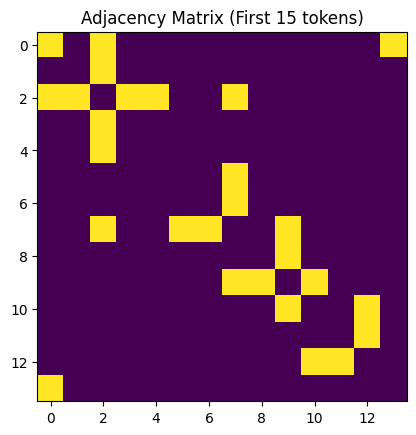

In [58]:
import matplotlib.pyplot as plt # Importing the pyplot module

# For first sample
plt.imshow(train_data.iloc[0]["adj_matrix"][:15,:15])
plt.title("Adjacency Matrix (First 15 tokens)")
plt.show()

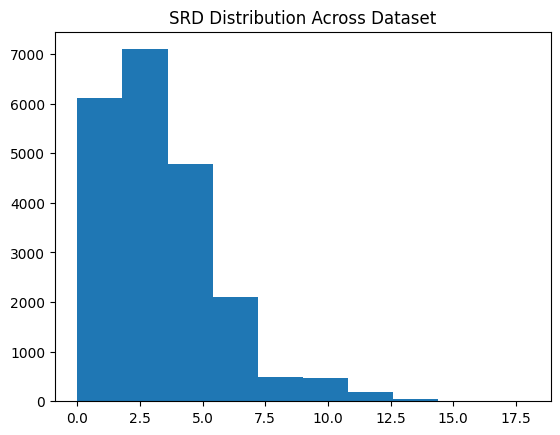

In [60]:
import numpy as np # Importing the numpy library with alias np

plt.hist(np.concatenate(train_data["SRD"].values)) # Now np is defined and can be used
plt.title("SRD Distribution Across Dataset")
plt.show()

In [43]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16,shuffle=False,num_workers=2)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel


In [45]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, adj_matrix, features):
        # Apply adjacency matrix to features
        out = torch.matmul(adj_matrix, features)
        out = self.fc(out)
        return out


In [46]:
class InteractiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(InteractiveAttention, self).__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, context, aspect):
        # Calculate attention scores between context and aspect
        scores = self.attn(context * aspect)
        attention_weights = torch.softmax(scores, dim=1)
        attended_features = context * attention_weights
        return attended_features


In [67]:
class IAGCN(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=300, num_classes=4):  # Change to 4
        super().__init__()
        # 1. Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        # 2. BiLSTM (Output: [batch, seq_len, hidden_dim])
        self.bilstm = nn.LSTM(embed_dim, hidden_dim // 2,
                             bidirectional=True, batch_first=True)

        # 3. GCN Layers
        self.gcn1 = nn.Linear(hidden_dim, hidden_dim)
        self.gcn2 = nn.Linear(hidden_dim, hidden_dim)

        # 4. Attention (Corrected for batch_first=True)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)

        # 5. Classifier (Input: 2*hidden_dim)
        self.classifier = nn.Linear(2 * hidden_dim, num_classes)  # Change to num_classes=4

    def forward(self, input_ids, adj_matrix, srd_weights, aspect_mask):
        # Embedding -> [batch, seq_len, 300]
        x = self.embedding(input_ids)

        # BiLSTM -> [batch, seq_len, 300]
        lstm_out, _ = self.bilstm(x)

        # GCN -> [batch, seq_len, 300]
        gcn_out = torch.matmul(adj_matrix, self.gcn1(lstm_out))
        gcn_out = torch.matmul(adj_matrix, self.gcn2(gcn_out))

        # Aspect Features -> [batch, seq_len, 300]
        aspect_features = gcn_out * aspect_mask.unsqueeze(-1)

        # Attention -> [batch, seq_len, 300]
        context_att, _ = self.attention(gcn_out, aspect_features, aspect_features)

        # Pooling -> [batch, 300]
        context_pool = context_att.mean(dim=1)
        aspect_pool = aspect_features.mean(dim=1)

        # Classification -> [batch, 4]  # Now outputs 4 classes
        logits = self.classifier(torch.cat([context_pool, aspect_pool], dim=1))
        return logits


In [68]:
import torch

# Check if a GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = IAGCN(
    vocab_size=len(tokenizer.vocab),
    embed_dim=300,
    hidden_dim=300
).to(device)

In [69]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Metrics
def calculate_metrics(preds, labels):
    acc = (preds == labels).float().mean()
    f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
    return acc.item(), f1

In [70]:
import torch.optim as optim
from sklearn.metrics import f1_score

# Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Metrics
def calculate_metrics(preds, labels):
    acc = (preds == labels).float().mean()
    f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted')
    return acc.item(), f1

best_val_f1 = 0
for epoch in range(20):
    # Training
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in train_loader:
        optimizer.zero_grad()

        inputs = batch['input_ids'].to(device)
        adj = batch['adj_matrix'].float().to(device)
        srd = batch['srd_weights'].float().to(device)
        mask = batch['aspect_mask'].float().to(device)
        labels = batch['labels'].to(device)

        outputs = model(inputs, adj, srd, mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    train_acc, train_f1 = calculate_metrics(torch.tensor(all_preds),
                                           torch.tensor(all_labels))

    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input_ids'].to(device)
            adj = batch['adj_matrix'].float().to(device)
            srd = batch['srd_weights'].float().to(device)
            mask = batch['aspect_mask'].float().to(device)
            labels = batch['labels'].to(device)

            outputs = model(inputs, adj, srd, mask)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

    val_acc, val_f1 = calculate_metrics(torch.tensor(val_preds),
                                       torch.tensor(val_labels))

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}")
    print(f"Train Loss: {total_loss/len(train_loader):.4f} | Acc: {train_acc:.2%} | F1: {train_f1:.4f}")
    print(f"Val Acc: {val_acc:.2%} | F1: {val_f1:.4f}\n")


Epoch 1
Train Loss: 1.3759 | Acc: 31.71% | F1: 0.2586
Val Acc: 39.91% | F1: 0.2373

Epoch 2
Train Loss: 1.3715 | Acc: 44.11% | F1: 0.2700
Val Acc: 39.06% | F1: 0.2194

Epoch 3
Train Loss: 1.3650 | Acc: 44.11% | F1: 0.2700
Val Acc: 39.06% | F1: 0.2194

Epoch 4
Train Loss: 1.3493 | Acc: 44.11% | F1: 0.2700
Val Acc: 39.06% | F1: 0.2194

Epoch 5
Train Loss: 1.2887 | Acc: 44.11% | F1: 0.2700
Val Acc: 39.06% | F1: 0.2194

Epoch 6
Train Loss: 1.2339 | Acc: 45.22% | F1: 0.2961
Val Acc: 39.48% | F1: 0.2322

Epoch 7
Train Loss: 1.2024 | Acc: 44.21% | F1: 0.2740
Val Acc: 39.06% | F1: 0.2194

Epoch 8
Train Loss: 1.1796 | Acc: 44.92% | F1: 0.2882
Val Acc: 39.48% | F1: 0.2322

Epoch 9
Train Loss: 1.1626 | Acc: 47.66% | F1: 0.3469
Val Acc: 38.63% | F1: 0.2297

Epoch 10
Train Loss: 1.1466 | Acc: 45.93% | F1: 0.3181
Val Acc: 39.48% | F1: 0.2316

Epoch 11
Train Loss: 1.1323 | Acc: 49.19% | F1: 0.3894
Val Acc: 38.63% | F1: 0.2297

Epoch 12
Train Loss: 1.1169 | Acc: 47.56% | F1: 0.3478
Val Acc: 41.20% | F

In [65]:
print(labels.unique())  # Check unique values in the labels


tensor([0, 1, 2, 3])


In [66]:
print(outputs.shape)

torch.Size([32, 3])
